In [3]:
!pip install -q decoupler
!pip install -q  mofax
!pip install -q muon
!pip install -q  omnipath
!pip install -q --upgrade liana

In [4]:
import pandas as pd
import scanpy as sc
import plotnine as p9
import decoupler as dc
import liana as li

from mudata import MuData

/opt/conda/lib/python3.9/site-packages/decoupler/method_wmean.py:38: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.


In [5]:
import numpy as np
import pandas as pd

import scanpy as sc

import plotnine as p9

import liana as li

# load muon and mofax
import muon as mu
import mofax as mofa

import decoupler as dc
import anndata as ad

/opt/conda/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/opt/conda/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/opt/conda/lib/python3.9/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba

# Spatial data

In [6]:
adata = sc.read("/data/raw_data/Cardiac_cells/Visium-FZ_GT_P19.h5ad")
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [7]:
adata.obsm["spatial"] = adata.obsm["X_spatial"]

In [8]:
li.ut.spatial_neighbors(adata, bandwidth=200, cutoff=0.1, kernel='gaussian', set_diag=True)


In [9]:
adata.var.index = adata.var["feature_name"].tolist()

In [10]:
li.mt.lr_bivar(adata,
               function_name='cosine', # Name of the function
               n_perms=100, # Number of permutations to calculate a p-value
               mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
               add_categories=True, # Whether to add local categories to the results
               expr_prop=0.2, # Minimum expr. proportion for ligands/receptors and their subunits
               use_raw=False,
               )

In [11]:
lrdata = adata.obsm['local_scores']


In [12]:
!pip install -q kneed

  0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
/opt/conda/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
100%|██████████| 9/9 [00:02<00:00,  3.86it/s]
Estimated rank: 3
/opt/conda/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.


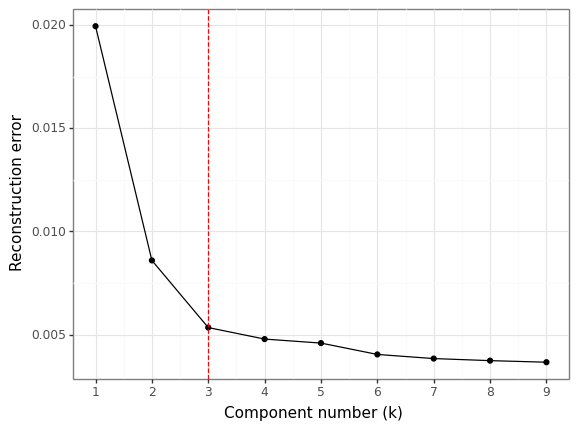

In [13]:
%matplotlib inline
li.multi.nmf(lrdata, n_components=None, inplace=True, random_state=0, max_iter=200, verbose=True)


In [15]:
li.mt.lr_bivar(

array([[0.44936836, 0.39293957, 0.4257221 , ..., 0.5269269 , 0.44114712,
        0.331459  ],
       [0.49758288, 0.40034148, 0.49011427, ..., 0.5928475 , 0.5095897 ,
        0.37271276],
       [0.4463086 , 0.35229635, 0.43045834, ..., 0.5946275 , 0.5156284 ,
        0.38092756],
       ...,
       [0.49984768, 0.40314102, 0.4876529 , ..., 0.5843991 , 0.5040196 ,
        0.36670515],
       [0.44397277, 0.36138076, 0.4256831 , ..., 0.5791167 , 0.50028443,
        0.36720702],
       [0.5233293 , 0.42033714, 0.5105254 , ..., 0.5777074 , 0.5031842 ,
        0.37450716]], dtype=float32)

In [17]:
lrdata.var

""
interaction
COL1A1^CD44
COL4A1^CD44
FN1^CD44
LAMB1^CD44
COL1A2^CD44
...
S100A1^RYR2
CALM1^AQP1
CALM2^AQP1


In [35]:
lr_loadings = li.ut.get_variable_loadings(lrdata, varm_key='NMF_H').set_index('index')


In [37]:
factor_scores = li.ut.get_factor_scores(lrdata, obsm_key='NMF_W')


In [39]:
nmf = sc.AnnData(X=lrdata.obsm['NMF_W'],
                 obs=lrdata.obs,
                 var=pd.DataFrame(index=lr_loadings.columns),
                 uns=lrdata.uns,
                 obsm=lrdata.obsm)

In [40]:
nmf.X = (nmf.X-np.min(nmf.X))/(np.max(nmf.X)-np.min(nmf.X))

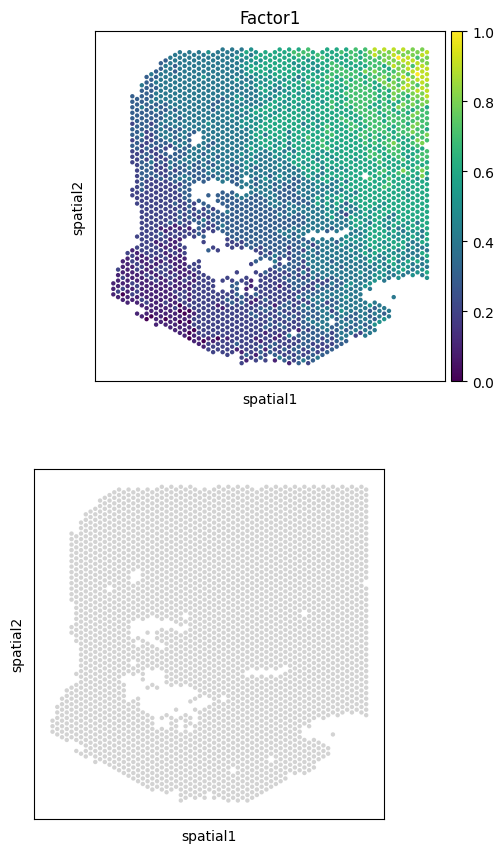

In [41]:
%matplotlib inline
sc.pl.spatial(nmf, color=[*nmf.var.index, None], size=1.4, ncols=1,spot_size=0.01)
#plt.ticklabel_format(

In [42]:
lr_loadings.sort_values("Factor1", ascending=False).head(10)


,Factor1
index,
TIMP1^CD63,2.353361
COL1A2^CD36,2.290879
COL1A1^CD36,2.257146
CCN2^LRP1,2.233111
CD99^CD81,2.228906
PSAP^LRP1,2.222259
LGALS1^ITGB1,2.162252
LUM^ITGB1,2.150075
C1QB^LRP1,2.137063


In [44]:
lrdata.uns['global_res'].sort_values("global_mean", ascending=False)

,interaction,ligand,ligand_means,ligand_props,receptor,receptor_means,receptor_props,global_mean,global_sd
1997,TIMP1^CD63,TIMP1,1.771804,0.743548,CD63,2.163210,0.873871,0.794127,1.550312e-07
643,COL1A2^CD36,COL1A2,2.695552,0.973871,CD36,1.502466,0.652258,0.772996,1.697459e-07
642,COL1A1^CD36,COL1A1,2.501117,0.935161,CD36,1.502466,0.652258,0.761637,1.600614e-07
73,CCN2^LRP1,CCN2,2.494080,0.935806,LRP1,1.334353,0.594516,0.753505,1.755540e-07
827,CD99^CD81,CD99,1.446151,0.646452,CD81,2.137288,0.864839,0.752134,1.306267e-07
...,...,...,...,...,...,...,...,...,...
271,COMP^ITGA5,COMP,0.477391,0.227742,ITGA5,0.570701,0.281290,0.259577,1.670277e-07
250,TFPI^SDC4,TFPI,0.607733,0.289677,SDC4,0.403991,0.202581,0.240307,4.711325e-08
55,LPL^CD44,LPL,1.123527,0.499677,CD44,0.463828,0.218387,0.237470,4.022156e-08
1663,TGFB1^LPP,TGFB1,0.505123,0.244839,LPP,0.419039,0.207742,0.236047,5.116478e-08
